(e_raster_reproject)=

----------------
```{admonition} Learning Objectives
- Creating raster data with Rasterio
- Creating raster data with Rasterio
```
```{admonition} Review
* [Affine transformation](d_affine.md)
* [Raster Coordinate Reference Systems](d_raster_crs_intro.md)
* [Geospatial Raster Data](c_rasters.md)
```
----------------
 

# Reading & Writing Rasters with Rasterio 
In order to work with raster data we will be using `rasterio` and later `geowombat`. Behind the scenes a `numpy.ndarray` does all the heavy lifting. To understand how raster works it helps to construct one from scratch. 

Here we create two `ndarray` objects one `X` spans [-90&deg;,90&deg;] longitude, and `Y` covers [-90&deg;,90&deg;] latitude.

In [1]:
import numpy as np
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)
X

array([[-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.]])

In [2]:
Y

array([[ 90.,  90.,  90.,  90.,  90.,  90.],
       [ 54.,  54.,  54.,  54.,  54.,  54.],
       [ 18.,  18.,  18.,  18.,  18.,  18.],
       [-18., -18., -18., -18., -18., -18.],
       [-54., -54., -54., -54., -54., -54.],
       [-90., -90., -90., -90., -90., -90.]])

Let's generate some data representing temperature and store it an array `Z`

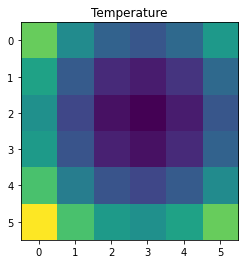

In [3]:
import matplotlib.pyplot as plt

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

## Creating Raster Data

The final array `Z` still lacks a number of elements that transform it from being a non-spatial `numpy` array to a spatial one usable by `rasterio` etc. `Rasterio` requires the following elements to write out a geotif, or spatial raster dataset:

| Parameters     | Description    | Argument      |
| :---          | ---:           |---:        |
| driver  | the name of the desired format driver   |  `'GTiff'` |
| width  | the number of columns of the dataset   |  `Z.shape[1]` |
| height  | the number of rows of the dataset   |  `Z.shape[0]` |
| count  | a count of the dataset bands   |  `1` |
| dtype  | the data type of the dataset   |  `Z.dtype` |
| crs  | a coordinate reference system identifier or description   |  `'+proj=latlong'`|
| transform  | an affine transformation matrix   |  `Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)`|
| nodata  | a “nodata” value   |  `-9999`|

```{note}
`transform` defines the location of the upper left hand corner of the raster on the globe, and its spatial resolution. The arguments for `transform` are complex and beyond the scope of the chapter, please refer to the next chapter @ [affine transforms](d_affine.md) and [raster crs](d_raster_crs_intro.md) for more info. 
```
## Writing Rasters
To save this array along with geospatial information to a file, we call `rasterio.open()` with a path to the new file to be created, and 'w' to specify writing mode, along with the arguments above.

In [4]:
import rasterio
from rasterio.transform import Affine

xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)

transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

with rasterio.open(
        "../temp/temperature.tif",
        mode="w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        crs="+proj=latlong",
        transform=transform,
) as new_dataset:
        new_dataset.write(Z, 1)


When we go to look again at our data we can read it back in using `open`. Before plotting we `raster.read(1)` the first band, which converts the data back to a `numpy` array that can be plotted in `matplotlib`.  Notice that we also specify the band number (in this case 1), with `.write(Z, 1)`.

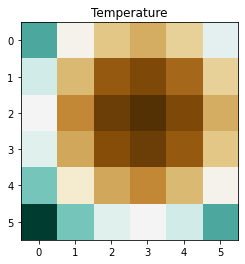

In [5]:
import matplotlib.pyplot as plt

raster = rasterio.open("../temp/temperature.tif")

plt.imshow(raster.read(1), cmap="BrBG")
plt.title("Temperature")
plt.show()

So in summary, a geospatial dataset is essentially just a `numpy.ndarray` with information about the location and resolution of the array, the [coordinate reference system](d_crs_what_is_it.md), and number of bands. This information is typically accessed and updated via the `.profile`.

In [6]:
print(raster.profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 6, 'height': 6, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(30.0, 0.0, -105.0,
       0.0, -30.0, 105.0), 'tiled': False, 'interleave': 'band'}


## Update Raster Metadata
Notice the the `.profile` above is missing a meaningful `nodata` value and was uncompressed. Let's learn how to update these values. For this we can update the `.profile` dictionary.

In [7]:
# start with the original profile
profile = raster.profile
# update values for nodata and compression type
profile.update(nodata=0, compress="lzw")
print(profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0, 'width': 6, 'height': 6, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(30.0, 0.0, -105.0,
       0.0, -30.0, 105.0), 'tiled': False, 'interleave': 'band', 'compress': 'lzw'}


Now we just need to write the array of data (obtained from `raster.read(1)`) out with the updated profile info. We can unpack all the dictionary values from the profile using `**profile`.

In [8]:
with rasterio.open("../temp/temperature.tif", 
                  mode="w", 
                  **profile,) as update_dataset:
    update_dataset.write(raster.read(1), 1)

## Rasterio Multiband Rasters 
Working with multiband imagery starts to get a bit tricky, especially with `rasterio` alone. 

Let's start with a problematic raster file, a landsat image that stores its red, green, and blue bands in reverse order (blue, green, red), that is scaled by 100 (multiplied by 100 to store data as integers rather than float), and that is missing a meaningful nodata value.

In [9]:
with rasterio.open(
    "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF", mode="r", nodata=0) as src:
    # read in the array, band 3 first, then band 2, then band 1
    arr = src.read([3, 2, 1])
    # the array has three bands
    print("Array shape:", arr.shape)
    # look at the profile, despite setting nodata=0, there still isn't a nodata value 
    # this is because we need to update the profile and write out a new image with
    #  nodata set
    profile = src.profile
    print(profile)

Array shape: (3, 1860, 2041)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2041, 'height': 1860, 'count': 3, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 717345.0,
       0.0, -30.0, -2776995.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


```{note}
We use `src.read([3, 2, 1])` in order to reverse the read order of our bands. With this the original blue, green, red order is read in reverse as red, green, blue, which is required for true color images. 
```

To see what it looks like, let's use rasterio's `show` function which *sort of helps* when viewing multiband imagery.

[[[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [6672 6168 6100 ... 6028 6015 6008]
  [6291 6457 6423 ... 6021 6001 6017]
  [6181 6727 6747 ... 6098 6023 5991]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [7083 6794 6731 ... 6760 6724 6685]
  [6951 7079 7016 ... 6699 6687 6715]
  [6864 7286 7338 ... 6817 6732 6659]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [7692 7518 7513 ... 7440 7432 7415]
  [7586 7590 7610 ... 7440 7411 7425]
  [7576 7743 7770 ... 7464 7443 7406]]]
--------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


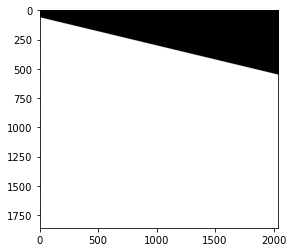

<AxesSubplot:>

In [10]:
from rasterio.plot import show
print(arr)
print('--------------')
show(arr)

Arg... it looks terrible. A few things, the primary problem is that the zeros aren't being treated as missing data, and therefor messing everything up. Second, there is a message at the top of the image saying its `clipping... [0..255] for integers)`. 

Let's check what the range of values are in our raster. To do this we will use `scipy` `stats`, and `.ravel()` to convert our `n` dimension array to a `1d` array.

In [11]:
from scipy import stats

print(stats.describe(arr.ravel()))

DescribeResult(nobs=11388780, minmax=(0, 24147), mean=6095.312502656123, variance=7725568.74402071, skewness=-1.6071105370358574, kurtosis=0.9303298625510847)


Since we currently have integer data that ranges from 0 to 24147, we should try scaling it, if we go to the documentation we would see that we need to divide all values by 100.

In [12]:
scaled_arr = arr / 100
print(scaled_arr.dtype)

float64


Then let's write the data back out again with an updated profile. Notice that the datatype (`dtype`) has changed since we divided by 100.

In [13]:
# update the profile for the new raster
profile = src.profile
profile.update(nodata=0, compress="lzw", dtype=scaled_arr.dtype)

# write out raster as RGB 
with rasterio.open(
    "../temp/LS_scaled_20200518.tif",
    mode="w",
    **profile,  # unpack the profile arguments set above
) as new_dataset:
    new_dataset.write(scaled_arr, [1, 2, 3])

```{note}
Since the bands have already been put in the right order in the array (ie. RGB), we can just write it out as follows `.write(scaled_arr, [1, 2, 3])`. 
```

There you go! A fixed raster. Try opening it in Qgis to make sure. We can look at it now using rasterio `show`, but again it isn't great, but better.

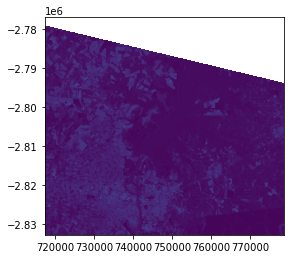

In [14]:
with rasterio.open("../temp/LS_scaled_20200518.tif", mode="r") as src:
    show(src,adjust='linear')

To help make all of this easier and more intuitive we will be presenting the use of `geowombat` for remote sensing applications later, [start here](f_rs_intro.md).

Just as a preview, here's how to do this in `geowombat`.

<xarray.DataArray 'band' (band: 3)>
array(['blue', 'green', 'red'], dtype='<U5')
Coordinates:
  * band     (band) <U5 'blue' 'green' 'red'


  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:00<00:00, 82.56it/s]

 36%|███▌      | 18/50 [00:00<00:00, 79.51it/s]

 52%|█████▏    | 26/50 [00:00<00:00, 78.19it/s]

 68%|██████▊   | 34/50 [00:00<00:00, 74.41it/s]

 84%|████████▍ | 42/50 [00:00<00:00, 75.57it/s]

100%|██████████| 50/50 [00:00<00:00, 76.03it/s]

100%|██████████| 50/50 [00:00<00:00, 76.54it/s]


  0%|          | 0/14 [00:00<?, ?it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 75.63it/s]

100%|██████████| 14/14 [00:00<00:00, 80.66it/s]

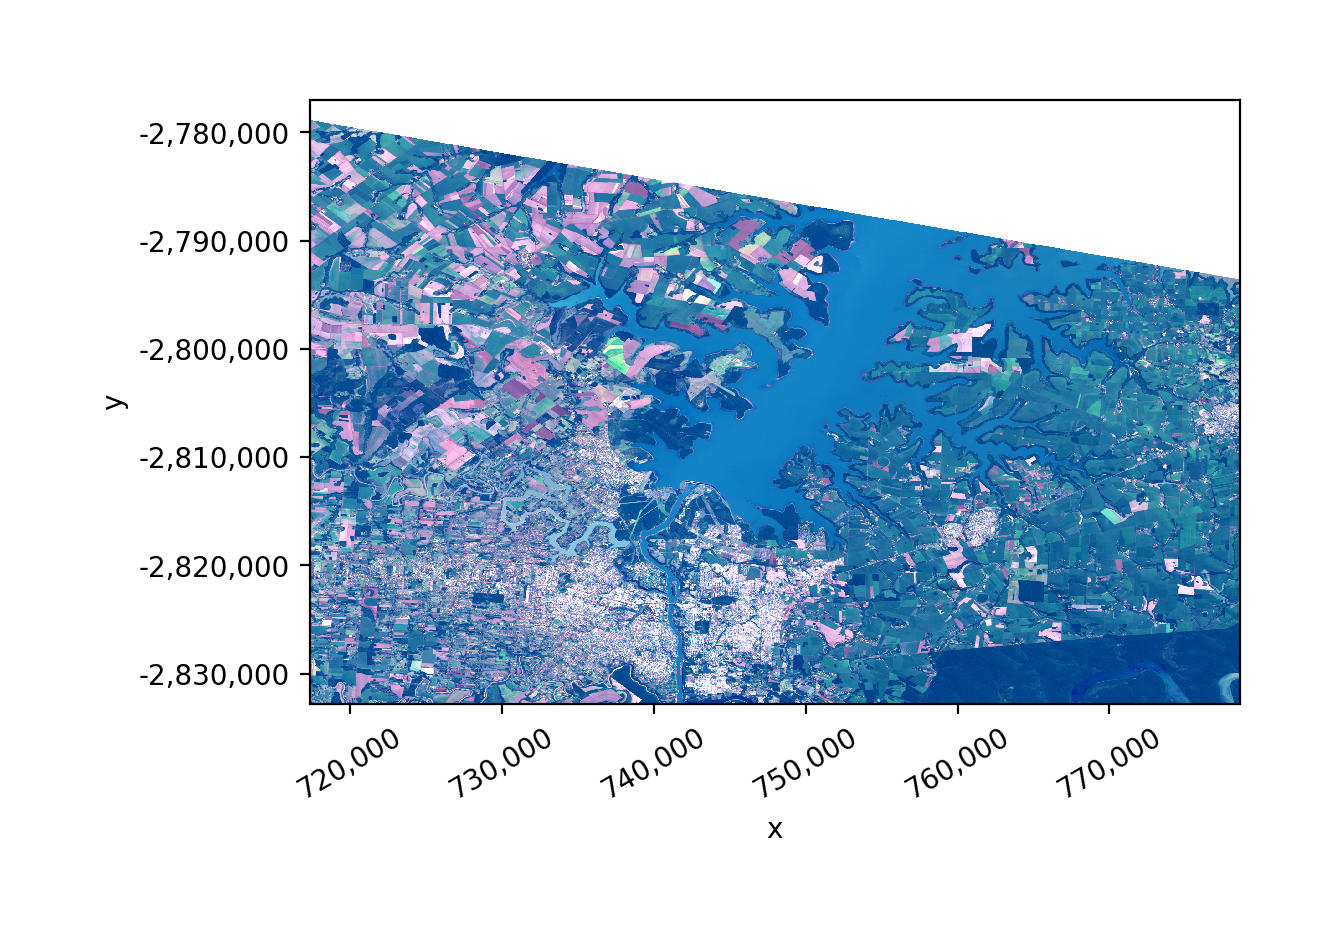

In [15]:
import geowombat as gw
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)

# tell gw to read a blue green red
with gw.config.update(sensor="bgr"):
    with gw.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:
        
        # see that bands names, blue green red are assigned
        print(src.band)

        # remove 0 value, rearrange band order 
        temp = src.where(src != 0).sel(band=["red", "green", "blue"])

        # plot
        temp.gw.imshow(robust=True, ax=ax)

        #save to file
        temp.gw.to_raster(
            "../temp/LS_scaled_20200518.tif", verbose=0, n_workers=4, overwrite=True
        )

----------
Credits: [rasterio quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html)